<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/lstm_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads imports and installs

In [1]:
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py

--2019-05-29 21:07:06--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-05-29 21:07:06--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-05-29 21:07:07 (78.6 MB/s) - ‘lib.py’ saved [5214/5214]



In [2]:
import IPython.display as lab
import ipywidgets as ipy_widgets
import google.colab.widgets as colab_widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
import functools
import keras
import lib

Using TensorFlow backend.


# Intro
this tutorial is made to learn keras datagenerators.

a small LSTM, procesing a input seqence of symbols and predicting a outputsymbol seqience is used snice data can be easyly generated.

format sings are used to gernated x samples, phython eval is used on the X to generate the Y values.

we a building a calculator.

### Encoding
a seqence of onehot encoded symbols s element alphabet, 
user defines input symbol seq len and output.

X.shape = (samples,  in_seqlen,  alphalen)   
Y.shape = (samples, out_seqlen,  alphalen)  

### Predicting a Sample
user will input a string, and want to read a string

for prediction encode -> predict -> decode is neccesary 
  
  
 

In [3]:
#@title Define context, sample dimensins { vertical-output: true }
alphabet        = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', ' '] #@param {type:""}

in_seq_len      = 5 #@param {type:"slider", min:2, max:20, step:1}
out_seq_len     = 4 #@param {type:"slider", min:1, max:10, step:1}
  
input_shape     = (in_seq_len,  len(alphabet))
output_shape    = (out_seq_len, len(alphabet))

print('input_shape:', input_shape, 'output_shape:', output_shape)

input_shape: (5, 14) output_shape: (4, 14)


In [0]:
int_to_char    = dict((i, c) for i, c in enumerate(alphabet))  
char_to_int    = dict((c, i) for i, c in enumerate(alphabet))

to_onehot      = lambda val: [1 if val==i else 0 for i in range(len(alphabet))] 

sample_encode  = lambda string:      [to_onehot(char_to_int[char]) for char in string]
sample_decode  = lambda hot: ''.join([int_to_char[np.argmax(step)] for step in hot])  

pad_r          = lambda s,l: s + ''.join([' ' for _ in range(l-len(s))])  
pad_l          = lambda s,l:     ''.join([' ' for _ in range(l-len(s))]) + s
pad            = pad_l

### Generating samples
data is generated as sting expresssin, by a formatstring, which is filled with random numbers [0,  max_int] 

a saple is created with its various encodings

In [0]:
class Sample:  
    def __init__(self, id, x, y, v, parameter_space):    
        self.ID = id
        self.Xstr = x
        self.Ystr = y 
        self.Xvalues = v
        self.Xoperators = o
        self.Xparameter = parameter
        self.Xhot = sample_encode(x)
        self.Yhot = sample_encode(y)
        self.XhotShape = np.array(self.Xhot).shape
        self.YhotShape = np.array(self.Yhot).shape
        
    def __str__(self):
        return "{}: '{}' = '{}'".format(self.ID, self.Xstr, self.Ystr)
    
    def compilePandaColumns(self):        
        return { name : getattr(self, name) for name in ['ID', 'Xstr', 'XhotShape', 'Ystr', 'YhotShape', 'Xvalues']}

    
class SampleParameters:
    def __init__(self, in_format, in_seq_len, var_count, out_format, out_seq_len, int_ranges):    
        self.in_seq_format = in_format
        self.in_seq_len = in_seq_len
        self.in_seq_vars = var_count
        self.out_seq_format = out_format
        self.out_seq_len = out_seq_len
        self.int_ranges = int_ranges
        
    def createSample(self, id):        
        random.seed(hash(id))
        rand_arr = self.createVariableSet()        
        x_exp_str = random.choice(self.in_seq_format).format(*rand_arr)
        y_val_str = self.out_seq_format.format(eval(x_exp_str))
        xstr = pad(x_exp_str, self.in_seq_len)
        ystr = pad(y_val_str, self.out_seq_len)
        return Sample(id, xstr, ystr, rand_arr, self)
        
    def createVariableSet(self):
        #return [random.randint(0, max_int) for _ in range(n)]     
        arr2d = [[random.randint(*range_sec) for _ in range(int(self.in_seq_vars /len(self.int_ranges)))] for range_sec in self.int_ranges]
        arr   = [item for sublist in arr2d for item in sublist]    
        random.shuffle(np.array(arr))
        return arr

# A batch of samples with a panda frame

create some samples, and extracts the enhot encoded seqences X and y as a numpy arrays


In [6]:
#@title Sample Factory { vertical-output: true }
int_ranges      = [(0, 50)]          #@param {type:"raw"}
#int_ranges      = [(0, 20), (30, 50)]          #@param {type:"raw"}
in_seq_format   = ['{:d}*{:d}', '{:d}+{:d}']   #@param
in_seq_vars     = 2                            #@param
out_seq_format  = '{:d}'                       #@param {type:"raw"}
out_seq_vars    = 'python eval of in_seq'      #@param {type:"raw"}

training_sample_parameters = [in_seq_format, in_seq_len, in_seq_vars, out_seq_format, out_seq_len, int_ranges]

s = SampleParameters(*training_sample_parameters).createSample("batch_demo/exp0")
print("generated string:", s)
print("encoded and back: batch_demo/exp0: '{}' = '{}'".format(sample_decode(s.Xhot), sample_decode(s.Yhot)))

generated string: batch_demo/exp0: ' 9*34' = ' 306'
encoded and back: batch_demo/exp0: ' 9*34' = ' 306'


(10, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
BID          10 non-null int64
ID           10 non-null object
XhotShape    10 non-null object
Xstr         10 non-null object
YhotShape    10 non-null object
Ystr         10 non-null object
values       10 non-null object
dtypes: int64(1), object(6)
memory usage: 640.0+ bytes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

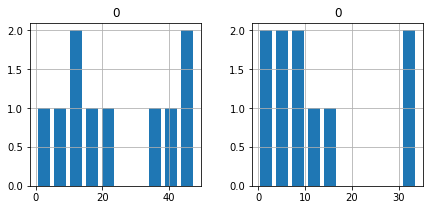

<IPython.core.display.Javascript object>

In [7]:
#@title Sample { vertical-output: true }
def generate_batch(set_path, sample_parameters, batch_size, batch_idx):
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        ID = "%s/exp%d"%(set_path, (batch_size * batch_idx) + i)
        s = SampleParameters(*sample_parameters).createSample(ID)        
        X.append(s.Xhot)
        y.append(s.Yhot)
        c.append({ 'BID':i, **s.compilePandaColumns()})    
    return np.array(X), np.array(y), pd.DataFrame(data=c)

def display_batch_stats(f):
    fig = plt.figure(figsize=(15, 3))    
    asnp = np.array(f['Xvalues'].to_list())
    for n in range(in_seq_vars):
        frame = pd.DataFrame(asnp[:, n])
        frame.hist(rwidth=.75, ax=fig.add_subplot(140+n+1))
    
def display_batch_meta(batch_panda):
    print(batch_panda.shape)
    t = colab_widgets.TabBar(["Info", "Plots"])    
    with t.output_to(0):
        batch_panda.info()
    with t.output_to(1):
        display_batch_stats(batch_panda)

        
a, b, f = generate_batch('batch_demo', training_sample_parameters, 10, 0)

display_batch_meta(f)

In [8]:
#@title Sample Batch with panda { run: "auto", vertical-output: true }
batch_view_len = 30 #@param {type:"slider", min:1, max:30, step:1}
    
def display_batch_content(batch, f_batch, batch_view_len):    
    print(a.shape, b.shape, f.shape)
    t = colab_widgets.TabBar(["Panda", "X Network encoding", "Y Network encoding", "Sample View"])
    
    visible_samples = min(batch_view_len, len(f_batch))
    with t.output_to(0):
        display(f_batch[0:visible_samples])
    
    with t.output_to(1):
        display(batch[0][0:visible_samples])        
    
    with t.output_to(2):
        display(batch[1][0:visible_samples])
    
    with t.output_to(3):
        for s in range(visible_samples):            
            print(SampleParameters(*training_sample_parameters).createSample(f_batch['ID'][s]))
            
display_batch_content((a, b), f, batch_view_len)

(10, 5, 14) (10, 4, 14) (10, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,ID,XhotShape,Xstr,YhotShape,Ystr,values
0,0,batch_demo/exp0,"(5, 14)",9*34,"(4, 14)",306,"[9, 34]"
1,1,batch_demo/exp1,"(5, 14)",22+15,"(4, 14)",37,"[22, 15]"
2,2,batch_demo/exp2,"(5, 14)",14*7,"(4, 14)",98,"[14, 7]"
3,3,batch_demo/exp3,"(5, 14)",19+34,"(4, 14)",53,"[19, 34]"
4,4,batch_demo/exp4,"(5, 14)",48*4,"(4, 14)",192,"[48, 4]"
5,5,batch_demo/exp5,"(5, 14)",40*3,"(4, 14)",120,"[40, 3]"
6,6,batch_demo/exp6,"(5, 14)",46*0,"(4, 14)",0,"[46, 0]"
7,7,batch_demo/exp7,"(5, 14)",11+5,"(4, 14)",16,"[11, 5]"
8,8,batch_demo/exp8,"(5, 14)",0*12,"(4, 14)",0,"[0, 12]"
9,9,batch_demo/exp9,"(5, 14)",37+9,"(4, 14)",46,"[37, 9]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

batch_demo/exp0: ' 9*34' = ' 306'
batch_demo/exp1: '22+15' = '  37'
batch_demo/exp2: ' 14*7' = '  98'
batch_demo/exp3: '19+34' = '  53'
batch_demo/exp4: ' 48*4' = ' 192'
batch_demo/exp5: ' 40*3' = ' 120'
batch_demo/exp6: ' 46*0' = '   0'
batch_demo/exp7: ' 11+5' = '  16'
batch_demo/exp8: ' 0*12' = '   0'
batch_demo/exp9: ' 37+9' = '  46'


<IPython.core.display.Javascript object>

# Training and Validation DataGenerator

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=(), out_dim=(), sample_parameters=None):        
        self.n_samples = samples
        self.batch_size = batch_size
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
        self.set_path = set_path
        self.sample_parameters = sample_parameters
        
        print('DataGenerator: samples=', self.n_samples, "batchsize=", 
              self.batch_size, "len=", int(np.floor(self.n_samples / self.batch_size)))
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx):        
        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
        #list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = np.empty((self.batch_size, *self.in_dim))
        y = np.empty((self.batch_size), dtype=int)        
        
        X, y, f = generate_batch(self.set_path, self.sample_parameters, self.batch_size, idx)        
        return X, y
    
    def renderFrame(self):
        panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.sample_parameters, self.batch_size, idx)
            panda = panda.append(f)    
        print(len(self), "Batches touched")
        #print(panda['file'])
        return self, panda

training_sample_parameters= [['{:d}*{:d}', '{:d}+{:d}'], 5, 2, '{:d}', 4, [(0, 50)]]
DataGenerator: samples= 5000 batchsize= 100 len= 50
50 Batches touched
DataGenerator: samples= 500 batchsize= 100 len= 5
5 Batches touched
(5000, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 99
Data columns (total 7 columns):
BID          5000 non-null int64
ID           5000 non-null object
XhotShape    5000 non-null object
Xstr         5000 non-null object
YhotShape    5000 non-null object
Ystr         5000 non-null object
values       5000 non-null object
dtypes: int64(1), object(6)
memory usage: 312.5+ KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

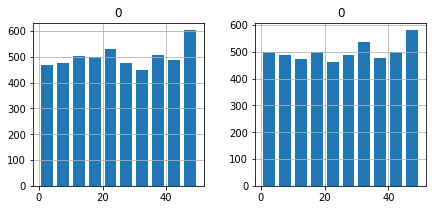

<IPython.core.display.Javascript object>

In [10]:
#@title Train/Validate Generators { vertical-output: true, output-height: 200 }
batch_size      = 100 #@param {type:"slider", min:1, max:300, step:10}
training_size   = 5000 #@param {type:"slider", min:1000, max:5000, step:100}
validation_size = 500 #@param {type:"slider", min:10, max:1000, step:10}

params = {
    'sample_parameters': training_sample_parameters,
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

print("training_sample_parameters=", training_sample_parameters)

training_generator, training_panda =     DataGenerator(samples=training_size, set_path="train", **params).renderFrame()
validation_generator, validation_panda = DataGenerator(samples=validation_size, set_path="validate", **params).renderFrame()

display_batch_meta(training_panda)

In [11]:
#@title Train/Test/Validate Generators { run: "auto", vertical-output: true, output-height: 200 }

batch_to_view  = 6 #@param {type:"slider", min:0, max:50, step:3}
batch_view_len = 20 #@param {type:"slider", min:1, max:20, step:1}

print("Training batches= ", len(training_generator))
print("Training Panda= ", len(training_panda))
print("batch_size= ", batch_size)
print(batch_to_view*batch_size, (batch_to_view+1)*batch_size)

display_batch_content(
    training_generator[batch_to_view], 
    training_panda[batch_to_view*batch_size:(batch_to_view+1)*batch_size], 
    batch_view_len
)

Training batches=  50
Training Panda=  5000
batch_size=  100
600 700
(10, 5, 14) (10, 4, 14) (10, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,ID,XhotShape,Xstr,YhotShape,Ystr,values
0,0,train/exp600,"(5, 14)",24+13,"(4, 14)",37,"[24, 13]"
1,1,train/exp601,"(5, 14)",38+9,"(4, 14)",47,"[38, 9]"
2,2,train/exp602,"(5, 14)",42*28,"(4, 14)",1176,"[42, 28]"
3,3,train/exp603,"(5, 14)",44*48,"(4, 14)",2112,"[44, 48]"
4,4,train/exp604,"(5, 14)",26*21,"(4, 14)",546,"[26, 21]"
5,5,train/exp605,"(5, 14)",19+33,"(4, 14)",52,"[19, 33]"
6,6,train/exp606,"(5, 14)",38*27,"(4, 14)",1026,"[38, 27]"
7,7,train/exp607,"(5, 14)",46+11,"(4, 14)",57,"[46, 11]"
8,8,train/exp608,"(5, 14)",3+24,"(4, 14)",27,"[3, 24]"
9,9,train/exp609,"(5, 14)",8*22,"(4, 14)",176,"[8, 22]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp600: '24+13' = '  37'
train/exp601: ' 38+9' = '  47'
train/exp602: '42*28' = '1176'
train/exp603: '44*48' = '2112'
train/exp604: '26*21' = ' 546'
train/exp605: '19+33' = '  52'
train/exp606: '38*27' = '1026'
train/exp607: '46+11' = '  57'
train/exp608: ' 3+24' = '  27'
train/exp609: ' 8*22' = ' 176'
train/exp610: ' 4*17' = '  68'
train/exp611: '35+49' = '  84'
train/exp612: '10+21' = '  31'
train/exp613: ' 9*35' = ' 315'
train/exp614: '50+46' = '  96'
train/exp615: '13+15' = '  28'
train/exp616: '41*22' = ' 902'
train/exp617: '46+43' = '  89'
train/exp618: ' 6*10' = '  60'
train/exp619: ' 5*31' = ' 155'


<IPython.core.display.Javascript object>

# Data is ready - Time for the network

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46000     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 14)             714       
Total params: 76,914
Trainable params: 76,914
Non-trainable params: 0
_________________________________________________________________
None


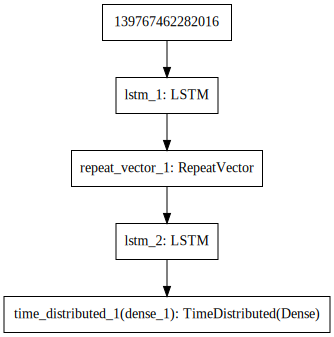

In [12]:
#@title Any LSTM configuration { vertical-output: true, output-height: 400 }
loss         = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
optimizer    = "adam"                     #@param ["adam" ,"other"]
main_metric  = "accuracy"                 #@param ["accuracy"]
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}
  
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector
  
model = Sequential()
model.add(LSTM(n1, input_shape=input_shape))
model.add(RepeatVector(out_seq_len))
model.add(LSTM(n2, return_sequences=True))
model.add(TimeDistributed(Dense(len(alphabet), activation='softmax')))
model.compile(loss=loss, optimizer=optimizer, metrics=[main_metric])

print(model.summary())
lab.SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

# Training

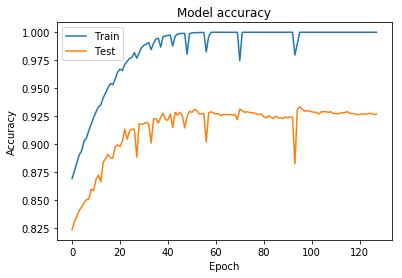

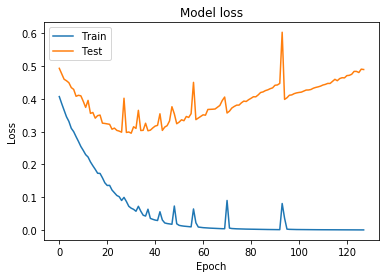

CPU times: user 10min 57s, sys: 2min 57s, total: 13min 54s
Wall time: 14min 26s


In [21]:
#@title Training { vertical-output: true }
%%time
steps_per_epoch    = 200 #@param {type:"slider", min:10, max:1000, step:1}
epochs             = 128 #@param {type:"slider", min:2, max:500, step:1}
use_multprocessing = True #@param {type:"boolean"}
workers            = 16 #@param {type:"slider", min:1, max:20, step:1}
verbose            = 0 #@param {type:"slider", min:0, max:5, step:1}

# samples in epoch, steps in epoch, samples per step, batches per step

history = model.fit_generator(  
  epochs = epochs,
  steps_per_epoch = steps_per_epoch,
  generator = training_generator,
  validation_data = validation_generator,                    
  use_multiprocessing = use_multprocessing,
  workers = workers,
  verbose = verbose,
  )#callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', sensible=2)])

lib.plot_history(history)

# Evaluation on testset with same parameters as Training set

In [0]:
#@title Create a sample by a given format string. calculate encodings. check encode/decode. { vertical-output: true }
int_ranges      = [(0, 50)]          #@param {type:"raw"}
in_seq_format   = ['{:d}*{:d}', '{:d}+{:d}']   #@param
in_seq_vars     = 2                            #@param
out_seq_format  = '{:d}'                       #@param {type:"raw"}
out_seq_vars    = 'python eval of in_seq'      #@param {type:"raw"}

test_sample_parameters = [in_seq_format, in_seq_len, in_seq_vars, out_seq_format, out_seq_len, int_ranges]

DataGenerator: samples= 1000 batchsize= 200 len= 5
5 Batches touched
(1000, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 199
Data columns (total 7 columns):
BID          1000 non-null int64
ID           1000 non-null object
XhotShape    1000 non-null object
Xstr         1000 non-null object
YhotShape    1000 non-null object
Ystr         1000 non-null object
values       1000 non-null object
dtypes: int64(1), object(6)
memory usage: 62.5+ KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

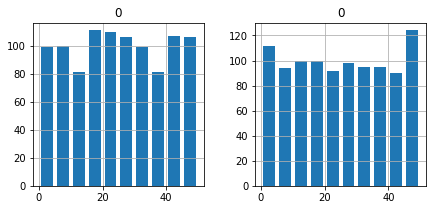

<IPython.core.display.Javascript object>

In [15]:
#@title Train/Test/Validate Generators { vertical-output: true, output-height: 200 }
batch_size      = 200 #@param {type:"slider", min:1, max:300, step:10}
test_size       = 1000 #@param {type:"slider", min:10, max:2000, step:10}

params = {
    'sample_parameters': test_sample_parameters,
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

test_generator, test_panda =  DataGenerator(samples=test_size, set_path="test", **params).renderFrame()
display_batch_meta(test_panda)

In [16]:
#@title View Test Generator { run: "auto", vertical-output: true, output-height: 200 }
batch_to_view = 0 #@param {type:"slider", min:0, max:5, step:1}
batch_view_len = 20 #@param {type:"slider", min:1, max:20, step:1}

print("Test batches= ", len(test_generator))
print("Slice", batch_to_view*batch_size, (batch_to_view+1)*batch_size)

display_batch_content(
    test_generator[batch_to_view], 
    test_panda[batch_to_view*batch_size:(batch_to_view+1)*batch_size], 
    batch_view_len
)

Test batches=  5
Slice 0 200
(10, 5, 14) (10, 4, 14) (10, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,ID,XhotShape,Xstr,YhotShape,Ystr,values
0,0,test/exp0,"(5, 14)",19+6,"(4, 14)",25,"[19, 6]"
1,1,test/exp1,"(5, 14)",1*27,"(4, 14)",27,"[1, 27]"
2,2,test/exp2,"(5, 14)",17*31,"(4, 14)",527,"[17, 31]"
3,3,test/exp3,"(5, 14)",21*40,"(4, 14)",840,"[21, 40]"
4,4,test/exp4,"(5, 14)",43*49,"(4, 14)",2107,"[43, 49]"
5,5,test/exp5,"(5, 14)",50+5,"(4, 14)",55,"[50, 5]"
6,6,test/exp6,"(5, 14)",31+23,"(4, 14)",54,"[31, 23]"
7,7,test/exp7,"(5, 14)",45*46,"(4, 14)",2070,"[45, 46]"
8,8,test/exp8,"(5, 14)",27+42,"(4, 14)",69,"[27, 42]"
9,9,test/exp9,"(5, 14)",44*9,"(4, 14)",396,"[44, 9]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp0: ' 19+6' = '  25'
test/exp1: ' 1*27' = '  27'
test/exp2: '17*31' = ' 527'
test/exp3: '21*40' = ' 840'
test/exp4: '43*49' = '2107'
test/exp5: ' 50+5' = '  55'
test/exp6: '31+23' = '  54'
test/exp7: '45*46' = '2070'
test/exp8: '27+42' = '  69'
test/exp9: ' 44*9' = ' 396'
test/exp10: ' 38*2' = '  76'
test/exp11: '23*31' = ' 713'
test/exp12: '10+46' = '  56'
test/exp13: '28+42' = '  70'
test/exp14: '12+13' = '  25'
test/exp15: ' 37+3' = '  40'
test/exp16: '42*35' = '1470'
test/exp17: '34+18' = '  52'
test/exp18: '38+35' = '  73'
test/exp19: '12*32' = ' 384'


<IPython.core.display.Javascript object>

In [17]:
#@title Show some errors by sample { vertical-output: true }
max_errors = 18 #@param {type:"slider", min:1, max:20, step:1}

# evaluate on some new patterns
X, y, f = generate_batch('test', test_sample_parameters, batch_size, 0)
print(X.shape, y.shape)

predicted = model.predict(X, verbose=1)

expected =  [sample_decode(s) for s in y]
predicted = [sample_decode(s) for s in predicted]

err_count = 0
for i in range(0, len(predicted)):
    if expected[i] != predicted[i]:
        err_count = err_count + 1
        if err_count < max_errors:
            print('%s: Expected=%s, Predicted=%s' % (f['ID'][i], expected[i], predicted[i]))  
            
print("expected != predicted Count:", err_count)

(200, 5, 14) (200, 4, 14)
200/200 [==============================] - 0s 1ms/step
test/exp2: Expected= 527, Predicted= 529
test/exp4: Expected=2107, Predicted=2911
test/exp7: Expected=2070, Predicted=2110
test/exp8: Expected=  69, Predicted=  79
test/exp9: Expected= 396, Predicted= 322
test/exp10: Expected=  76, Predicted=  96
test/exp11: Expected= 713, Predicted= 697
test/exp16: Expected=1470, Predicted=1430
test/exp18: Expected=  73, Predicted=  79
test/exp19: Expected= 384, Predicted= 382
test/exp24: Expected= 432, Predicted= 448
test/exp26: Expected=  90, Predicted=  80
test/exp28: Expected=  56, Predicted=  66
test/exp29: Expected= 369, Predicted= 399
test/exp30: Expected=  36, Predicted=  42
test/exp33: Expected= 564, Predicted= 594
test/exp36: Expected=1248, Predicted=1344
expected != predicted Count: 98


In [18]:
#@title Test Metrics { vertical-output: true }
"Accuracy %s" % model.evaluate_generator(test_generator)[1]

'Accuracy 0.8289999961853027'

In [19]:
#@title Use trained Model  { vertical-output: true }
def calculate(inp):
    print(inp, '=')
    padded = pad(inp, in_seq_len)  
    X = np.array([sample_encode(padded)])  
    result = model.predict(X)
    return sample_decode(result[0])

print(calculate('3*7'), "should be", 3*7)
print(calculate('3+7'), "should be", 3+7)
print(calculate('23*27'), "should be", 23*27)
print(calculate('23+27'), "should be", 23+27)
print(calculate('13*18'), "(maybe interpolated) should be", 13*18)
print(calculate('13+18'), "(maybe interpolated) should be", 13+18)

3*7 =
  21 should be 21
3+7 =
  10 should be 10
23*27 =
 699 should be 621
23+27 =
  50 should be 50
13*18 =
 216 (maybe interpolated) should be 234
13+18 =
  31 (maybe interpolated) should be 31


# Evaluation on testset with OTHER parameters like filled gap, or x out of training bounds

In [20]:
#@title Use trained Model  { vertical-output: true }
print(calculate('3*43'),  "(extrapolated) should be", 3*43)
print(calculate('43*43'),  "(extrapolated) should be", 43*43)

3*43 =
 199 (extrapolated) should be 129
43*43 =
1899 (extrapolated) should be 1849
